# 与机器学习框架的整合

## 前言

在过去的章节中，我们学习了机器学习编译的抽象和张量函数之间的变换。

本章将讨论如何将机器学习模型从现有的机器学习框架引入 MLC 流程。

## 准备工作

首先，我们导入必要的依赖项。

In [5]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
from tvm import relax
import numpy as np

# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

## 通过 Builder 构造 IRModule

在过去的章节中，我们一直在通过直接编写 TVMScript 来构建 IRModule。 随着模型变得越来越大，我们需要一种编程方式来构建 IRModule。在本节中，我们回顾一些支持该过程的工具。

### 从张量表达式构造 TensorIR
- 编写TVMScript来构建TensorIR
- 通过张良表达式构建

首先，我们回顾张量表达式 (tensor expression, TE) 这一领域特定语言来构建 TensorIR 函数。

In [6]:
from tvm import te

我们首先创建一个 placeholder，它表示 TensorIR 函数的输入。

In [7]:
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")

这里的每个输入和中间结果都表示为一个 `te.Tensor` 对象。

In [8]:
type(A)

tvm.te.tensor.Tensor

每个 `te.Tensor` 都有一个 shape 字段和 dtype 字段，用于记录计算的 shape 和数据类型。

A.shape

我们可以通过一系列张量表达式来描述计算。这里的 `te.compute` 使用 `te.compute(output_shape, fcompute)` 这样的接口，该接口接收输入的尺寸以及计算的张量表达式。fcompute 函数描述了我们要如何计算给定索引的每个元素 `[i, j]` 的值。

`te_matmul` 函数接受一个 `te.Tensor` 类型的对象，并返回矩阵乘法结果。请注意我们是如何根据 A 和 B 的输入 shape 构造计算的。`te_matmul` 适用于具有不同输入 shape 的 A 和 B。**在构建输入输出的placeholder后确定维度。**

In [9]:
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

我们可以使用 A 和 B 获得调用 `te_matmul` 的结果。

In [10]:
C = te_matmul(A, B)

要创建 TensorIR 函数，我们可以调用 `te.create_prim_func` 并传入输入和输出值。

In [11]:
te.create_prim_func([A, B, C]).show()

# from tvm.script import tir as T
@T.prim_func
def func(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(128, 128), "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0, i1, i2 in T.grid(128, 128, 128):
        with T.block("matmul"):
            i, j, k = T.axis.remap("SSR", [i0, i1, i2])
            T.reads(A[i, k], B[k, j])
            T.writes(matmul[i, j])
            with T.init():
                matmul[i, j] = T.float32(0)
            matmul[i, j] = matmul[i, j] + A[i, k] * B[k, j]



我们可以用类似的方式为 ReLU 计算创建张量表达式。在这里，我们写一个可以适用于具有任何维度数量和 shape 的 `te.Tensor` 的 `te_relu` 函数。

tips: *i -> i可以是任意长度的参数

In [12]:
def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

让我们在两种不同的输入维度数量和 shape 上尝试 `te_relu`。 第一个 `X1` 的尺寸为 `(10,)`。

In [13]:
X1 = te.placeholder((10,), name="X1", dtype="float32")
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

# from tvm.script import tir as T
@T.prim_func
def func(X1: T.Buffer[10, "float32"], relu: T.Buffer[10, "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0 in T.serial(10):
        with T.block("relu"):
            i0_1 = T.axis.spatial(10, i0)
            T.reads(X1[i0_1])
            T.writes(relu[i0_1])
            relu[i0_1] = T.max(X1[i0_1], T.float32(0))



然后是形状为 `(10, 20)` 的 `X2`。

In [14]:
X2 = te.placeholder((10, 20), name="X1", dtype="float32")
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

# from tvm.script import tir as T
@T.prim_func
def func(X1: T.Buffer[(10, 20), "float32"], relu: T.Buffer[(10, 20), "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0, i1 in T.grid(10, 20):
        with T.block("relu"):
            i0_1, i1_1 = T.axis.remap("SS", [i0, i1])
            T.reads(X1[i0_1, i1_1])
            T.writes(relu[i0_1, i1_1])
            relu[i0_1, i1_1] = T.max(X1[i0_1, i1_1], T.float32(0))



`te` API 允许我们做的另一件事是组合操作并创建“融合 (fused)”算子。例如，我们可以将 matmul 的结果再次应用 relu。

In [15]:
C = te_matmul(A, B)
D = te_relu(C)

我们可以通过只传递感兴趣的输入和输出值，跳过中间值来创建一个 TensorIR 函数。 这将导致 matmul 的结果被分配为 TensorIR 函数中的**临时空间**。

In [16]:
te.create_prim_func([A, B, D]).show()

# from tvm.script import tir as T
@T.prim_func
def func(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], relu: T.Buffer[(128, 128), "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    matmul = T.alloc_buffer([128, 128], dtype="float32")
    for i0, i1, i2 in T.grid(128, 128, 128):
        with T.block("matmul"):
            i, j, k = T.axis.remap("SSR", [i0, i1, i2])
            T.reads(A[i, k], B[k, j])
            T.writes(matmul[i, j])
            with T.init():
                matmul[i, j] = T.float32(0)
            matmul[i, j] = matmul[i, j] + A[i, k] * B[k, j]
    for i0, i1 in T.grid(128, 128):
        with T.block("relu"):
            i0_1, i1_1 = T.axis.remap("SS", [i0, i1])
            T.reads(matmul[i0_1, i1_1])
            T.writes(relu[i0_1, i1_1])
            relu[i0_1, i1_1] = T.max(matmul[i0_1, i1_1], T.float32(0))



我们还可以将中间结果 C 传递到参数列表中。在这种情况下，TensorIR 函数希望我们也从调用方传入 C。通常我们建议只传入输入和输出，这样我们就可以在里面进行更高级的融合。

In [17]:
te.create_prim_func([A, B, C, D]).show()

# from tvm.script import tir as T
@T.prim_func
def func(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(128, 128), "float32"], relu: T.Buffer[(128, 128), "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0, i1, i2 in T.grid(128, 128, 128):
        with T.block("matmul"):
            i, j, k = T.axis.remap("SSR", [i0, i1, i2])
            T.reads(A[i, k], B[k, j])
            T.writes(matmul[i, j])
            with T.init():
                matmul[i, j] = T.float32(0)
            matmul[i, j] = matmul[i, j] + A[i, k] * B[k, j]
    for i0, i1 in T.grid(128, 128):
        with T.block("relu"):
            i0_1, i1_1 = T.axis.remap("SS", [i0, i1])
            T.reads(matmul[i0_1, i1_1])
            T.writes(relu[i0_1, i1_1])
            relu[i0_1, i1_1] = T.max(matmul[i0_1, i1_1], T.float32(0))



### 使用 BlockBuilder 构造 IRModule

到目前为止，我们已经创建了一个 TensorIR 函数。 为了构建端到端的模型执行，我们还需要能够通过计算图连接多个 TensorIR 函数。

让我们首先创建一个 block builder，它可以帮助我们逐步构建一个 `relax.Function`。

In [18]:
A = relax.Var("A", (128, 128), relax.DynTensorType(2, "float32"))
B = relax.Var("B", (128, 128), relax.DynTensorType(2, "float32"))

我们通过创建 block builder 和一系列元张量函数来构造 Relax 函数。

In [19]:
bb = relax.BlockBuilder()

with bb.function("main"):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def te_matmul(rxplaceholder: T.Buffer[(128, 128), "float32"], rxplaceholder_1: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(128, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_matmul", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1, i2 in T.grid(128, 128, 128):
            with T.block("matmul"):
                i, j, k = T.axis.remap("SSR", [i0, i1, i2])
                T.reads(rxplaceholder[i, k], rxplaceholder_1[k, j])
                T.writes(matmul[i, j])
                with T.init():
                    matmul[i, j] = T.float32(0)
                matmul[i, j] = matmul[i, j] + rxplaceholder[i, k] * rxplaceholder_1[k, j]
    
    @T.prim_func
    def te_relu(rxplaceholder: T.Buffer[(128, 128), "float32"], relu: T.Buffer[(128, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_relu", 

### 深入理解 BlockBuilder API

现在让我们深入了解 BlockBuilder 的 API。将 BlockBuilder 代码和生成的 IRModule 并排放置会很有帮助。

![](../img/integration_block_builder.png)

BlockBuilder 带有与 Relax 函数中相应的作用域。例如，`bb.dataflow()` 创建一个 dataflow block，其中所有对 BlockBuilder 的调用都处在 dataflow block 的作用域中。**dataflow中的计算均没有side effect**。

```python
with bb.function("main"):
    with bb.dataflow():
        # every emit call generates a variable inside a dataflow block.
```

每个中间结果都是一个 `relax.Var`，对应一个存储计算结果的变量。 `DataflowVar` 表示该变量是 dataflow block（和计算图）内的中间步骤。

In [20]:
type(C)

tvm.relax.expr.DataflowVar

In [21]:
isinstance(C, relax.Var)

# isinstance() 与 type() 区别：
# type() 不会认为子类是一种父类类型，不考虑继承关系。
# isinstance() 会认为子类是一种父类类型，考虑继承关系。
# 如果要判断两个类型是否相同推荐使用 isinstance()

True

Relax 函数中的每一行都是由 `emit_te` 调用生成的。 例如，

```python
lv = R.call_tir(te_matmul, (A, B), (128, 128), dtype="float32")
```

是由如下代码所生成。

```python
C = bb.emit_te(te_matmul, A, B).
```

在幕后，`bb.emit_te` 做了以下事情：

- 为 A 和 B 创建一个输入 `te.placeholder`，
- 通过 `te_matmul` 函数运行它们。
- 调用 `te.create_prim_func` 来创建一个 TensorIR 函数。
- 通过 `call_tir` 生成对函数的调用。

我们可以发现，上面 BlockBuilder 构造后的结果是一个有两个中间值的计算图，一个节点对应 `te_matmul` 操作，另一个节点对应 `te_relu`。

我们可以通过 `bb.emit_output` 创建每个 dataflow block 的输出变量。

```python
with bb.dataflow():
    ...
    R = bb.emit_output(D)
```

上面的代码标志着 `D` 是一个可以在 dataflow block 之外引用的变量。

最后，函数输出由 `bb.emit_func_output` 标记。 我们只能在每个函数作用域内调用一次 `emit_func_output`。

值得注意的是，我们可以在输出阶段指定函数的参数列表。 这样做在我们动态收集参数列表的情况下会有帮助。

```python
with bb.function("main"):
    ...
    # specify parameters in the end
    bb.emit_func_output(R, params=[A, B])
```

或者，我们也可以在函数范围的开头指定参数列表。

```python
# specify parameters in the beginning.
with bb.function("main", params=[A, B]):
    ...
    bb.emit_func_output(R)
```

## 从 PyTorch 导入模型

现在我们已经学习了以编程方式构建 IRModule 的工具。 让我们使用它们将机器学习模型从 PyTorch 导入成为 IRModule。

大多数机器学习框架都带有计算图抽象，其中每个节点对应一个操作，边对应它们之间的依赖关系。 我们将采用 PyTorch 模型，获取 PyTorch 原生格式的计算图，并将其转换为 IRModule。

让我们从在 PyTorch 中定义一个模型开始。 为了使示例保持一致，我们将使用 matmul + ReLU 示例。

In [22]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

### 创建 TorchFX GraphModule

我们使用 TorchFX 来表示来自 PyTorch 的模型的计算图。

In [23]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
type(fx_module) # fx_module表示计算图

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

`fx_module` 包含一个简单的计算图，可以打印成表格便于查看。我们的目标是**将此图转换为 IRModule**。

In [24]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7fdd897759a0>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7fdd897759a0>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


### 构造映射函数

让我们定义整体的翻译逻辑。 主要流程如下：

- 创建一个 `node_map`，将 `fx.Node` 映射到相应的 `relax.Var`，该 `relax.Var` 代表 IRModule 中的已翻译节点。
- 以拓扑顺序迭代 FX 图中的节点。
- 给定映射输入，获取节点的映射输出。

In [25]:
def map_param(param: nn.Parameter):
    ndim = len(param.data.shape)
    # 把nn.Parameter参数映射到常数里
    return relax.const(
        param.data.cpu().numpy(), relax.DynTensorType(ndim, "float32")
    )

def fetch_attr(fx_mod, target: str):
    """Helper function to fetch an attr"""
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

# 将给定的fx module计算图转化为对应的ir module计算图
def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            # 迭代计算图中节点（拓扑排序后）进行变换
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder": # input
                    # create input placeholder
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, shape, relax.DynTensorType(len(shape), "float32")
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr": # fx_mod.weight -> 
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        # output and finalize the function
        bb.emit_func_output(output, fn_inputs)
    return bb.get()

我们没有在 `from_fx` 函数中定义函数映射。 我们将通过映射提供每个 torch function 的翻译规则。 具体来说，以下代码块显示了我们如何通过 `emit_te` API 做到这一点。

In [26]:
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B) # 返回生成的tensor expression

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = { # 指定映射
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def te_matmul(rxplaceholder: T.Buffer[(1, 128), "float32"], rxplaceholder_1: T.Buffer[(128, 128), "float32"], matmul: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_matmul", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1, i2 in T.grid(1, 128, 128):
            with T.block("matmul"):
                i, j, k = T.axis.remap("SSR", [i0, i1, i2])
                T.reads(rxplaceholder[i, k], rxplaceholder_1[k, j])
                T.writes(matmul[i, j])
                with T.init():
                    matmul[i, j] = T.float32(0)
                matmul[i, j] = matmul[i, j] + rxplaceholder[i, k] * rxplaceholder_1[k, j]
    
    @T.prim_func
    def te_relu(rxplaceholder: T.Buffer[(1, 128), "float32"], relu: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_relu", "tir.noali

## 回到 FashionMNIST 的例子

In [27]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

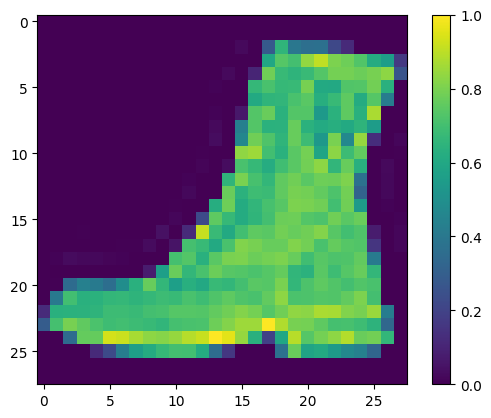

Class: Ankle boot


In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [29]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-08-19 17:24:02--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-08-19 17:24:03--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 0.0.0.0, ::
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|0.0.0.0|:443... failed: Connection refused.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|::|:443... failed: Connection refused.


以上是我们关心的模型，我们可以按如下的方式构建其 PyTorch 模型。

In [32]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [33]:
import pickle as pkl
mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

In [34]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: Ankle boot


让我们尝试通过为相应的 `nn.Module` 定义映射函数来从 FX 转换。 在这里，我们重用了来自 TVM TOPI (TVM operator inventory) 的预定义 TE 库，而不是定义我们自己的张量表达式。

- `topi.nn.dense(x, w)` 执行转置矩阵乘法`x @ w.T`
- `topi.add` 执行广播加法。

In [35]:
from tvm import topi

def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]   # input
    w = map_param(nn_mod.weight) # weight
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias) # bias
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)


MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },
)

MLPModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def te_relu(rxplaceholder: T.Buffer[(1, 128), "float32"], relu: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "te_relu", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, i1 in T.grid(1, 128):
            with T.block("relu"):
                i0_1, i1_1 = T.axis.remap("SS", [i0, i1])
                T.reads(rxplaceholder[i0_1, i1_1])
                T.writes(relu[i0_1, i1_1])
                relu[i0_1, i1_1] = T.max(rxplaceholder[i0_1, i1_1], T.float32(0))
    
    @R.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv = R.call_tir(dense, (x, meta[relay.Constant][0]), (1, 128), dtype="float32")
            lv1 = R.call_tir(add, (lv, meta[relay.Constant][1]), (1, 128), dtype="float32")
            lv2 = R.call_tir(te_relu, (lv1,), (1, 128)

In [36]:
ex = relax.vm.build(MLPModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Ankle boot


## 备注：翻译成高层算子

在大多数机器学习框架中，有时先转换为更高一级的内置的原始算子会更有帮助。下面的代码块给出了一个例子来做到这一点。


In [37]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit(relax.op.dense(x, w))
    return bb.emit(relax.op.add(y, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv: Tensor((1, 128), "float32") = relax.nn.dense(x, meta[relay.Constant][0])
            lv1: Tensor((1, 128), "float32") = relax.add(lv, meta[relay.Constant][1])
            lv2: Tensor((1, 128), "float32") = relax.nn.relu(lv1)
            lv3: Tensor((1, 10), "float32") = relax.nn.dense(lv2, meta[relay.Constant][2])
            lv4: Tensor((1, 10), "float32") = relax.add(lv3, meta[relay.Constant][3])
            gv: Tensor((1, 10), "float32") = lv4
            R.output(gv)
        return lv4
    



上面展示了我们使用那些内置的算子将模型导入为 IRModule 后的结果。这些内置算子是 **比 TensorIR 函数更高级别的抽象**。我们可以有不同的机会将这些原始算子进一步转换为库函数或 TensorIR 函数。

在大多数情况下，在有高级算子支持的情况下，转换为高级内置函数会很有帮助。但是，有很多情况下我们找不到对应的高级内置算子或者想直接指定 TensorIR 函数。 在这些情况下，我们可以自定义翻译逻辑或变换从而生成 `call_tir` 或调用库函数。 通常，我们可以结合高级操作、TensorIR 和库抽象来获得最佳结果。 我们将在后续章节中讨论权衡取舍。

## 讨论

在本章中，我们重点关注了 MLC 流程的 **开发** 部分。 我们研究了从机器学习框架中获取模型到 IRModule 的不同方法。 我们还简要介绍了高级原始运算符。

一旦我们将模型放入 IRModule 中，我们就可以在原始函数和计算图函数上引入更多种类的变换。一个好的 MLC 流程将这些转换组合在一起，形成最终部署形式。

![](../img/mlc_process.png)

## 总结

- 张量表达式 API 允许我们创建原始的 TensorIR 函数。
- BlockBuilder API 通过 `emit_te` 和其他函数创建 IRModule。
- 通过将模型转换为 IRModule，实现与现有的机器学习框架的整合。
